<h1>Microbiome Data Augmentation Using Dynamic Time Warping (DTW) and  Barycentric Averaging (DBA)</h1>

In [1]:

from utils.utils import transform_labels

from augment import augment_train_set

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import pickle
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
import seaborn as sns
import json

In [7]:
import numpy as np
import pandas as pd


In [8]:
%matplotlib inline

# Motivation

In machine learning, data augmentation is the process of creating synthetic examples in order to augment a dataset used to learn a model. Microbiome data is characterized with high dimensionality with very few samples obtained in a longitudinal study. Typical data augmentation for time series via spline interpolation combined with a Guassian noise would increase the resoltution within a microbiome sample. However this approach would not allow us to simulate new subjects. In our project, we have data from 9 mice at hand, each sampled ca. 75 times. Our data augmentation is to simulate additional mice.

Lately, applying Dynamic Time Warping (DTW) combined with non-parametric nearest neighbor (NN) has shown good results in time series classification. Especially the weighted version of time series by Barycentric Averaging (DBA) allows to create synthetic time series from a given set of time series. This method has been proposed by [G. Forestier a.l.](https://germain-forestier.info/publis/icdm2017.pdf) for augmenting sparse datasets. This technique of data augmentation has proven to drastically increase deep CNN’s accuracy. [H. Fawaz et.al.](https://germain-forestier.info/publis/aaltd2018.pdf) recently proposed a Python implementation of the DTW-DBA algorithm, wich we adapted for our project on microbiome timeseries. 

The algorithm starts by choosing randomly a time series and gives it a weight of 1. Then, it finds its nearest neighbor and gives it a weight of 0.5. Then it defines an exponential decay function that maps a distance to a weight. The function is used to decide upon the weights for all time series. 

# Data Augmentation by DTW-DBA

We cloned the [GitHub](https://github.com/hfawaz/aaltd18) repository of DTW-DBA implementation. On JupyterHub, we have to run the command `./utils/build-cython.sh` to compile the optimized DTW code written in Cython. 

In [4]:
from augment import augment_train_set

The function below is a helper function takes a multivariate time series `X`, the corresponding labels vector `Y` and produces `2^nb_multiply` times additional time series. 

In our microbiome context, `X` is a 3D matrix, where dimension 1 represents a subject (mouse), dimension 2 represents the time (sample) and finally dimension 3 represents an OTU. The matrix contains the abundance for the given subject, sample, time. The vector `Y` has a binary value, 0 for healthy subjects, and 1 for IBD subjects.

Assuming that `X` contains data for 4 healthy mice, and `nb_multiply` is 2, the function will return simulated samples for 12 'virtual' mice, for each time point and for each OTU.

In [40]:
Y, Y = transform_labels(ts_abundance_y_healthy, ts_abundance_y_healthy)
Y.shape, ts_abundance_y_healthy.shape

((4,), (4,))

In [21]:

def augment_ts(X, Y, nb_multiply=2):  
    
    print("Remaining: ", nb_multiply)
    
    if nb_multiply==0:
        return X, Y
    #Y, Y = transform_labels(Y, Y)
    classes, classes_counts = np.unique(Y, return_counts=True)
    nb_classes = len(np.unique(Y, axis=0))
    _, classes_counts = np.unique(Y, return_counts=True)
    nb_prototypes = classes_counts.max()
    if len(X.shape) == 2:  # if univariate 
            # add a dimension to make it multivariate with one dimension 
            X = X.reshape((X.shape[0], X.shape[1], 1))
    syn_train_set = augment_train_set(X, Y, classes,nb_prototypes,limit_N=False,
                                 weights_method_name='as', distance_algorithm='dtw')  
    # get the synthetic train and labels
    syn_X, syn_Y = syn_train_set
    # concat the synthetic with the reduced random train and labels
    aug_X = np.array(X.tolist() + syn_X.tolist())
    aug_Y = np.array(Y.tolist() + syn_Y.tolist())
    
    np.save('aug_X_{}.npy'.format(Y[0]), aug_X)
    np.save('aug_Y_{}.npy'.format(Y[0]), aug_Y)
    
    aug_X, aug_Y = augment_ts(aug_X, aug_Y, nb_multiply-1)

    return aug_X, aug_Y

Below we import our mouse dataset.

In [7]:

data_folder = '../Microbiome_Module_Material/Part c full processed data/'
with open(data_folder + 'mouse_set_data_merged_20190508.pkl', 'rb') as handle:
    df_all = pickle.load(handle)    
df_all.head()

,group,mouse,phase,day,hour,time_i,time_str,sample,otu,sequence,abundance,total_abundance,qpcr,mass,kingdom,phylum,class,order,family,genus
0,1,2,1,0,AM,0.0,0AM,2d0am,OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,1094,1094,8.724134e+06,3.25852e+06,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
1,1,2,1,0,AM,0.0,0AM,2d0am,OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,180,1274,8.724134e+06,536137,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
2,1,2,1,0,AM,0.0,0AM,2d0am,OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,10,1284,8.724134e+06,29785.4,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Akkermansia
3,1,2,1,0,AM,0.0,0AM,2d0am,OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,3,1287,8.724134e+06,8935.61,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
4,1,2,1,0,AM,0.0,0AM,2d0am,OTU_5,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,6,1293,8.724134e+06,17871.2,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Akkermansia


The function below takes the mice data frame and returns the matrix `X` and `Y`, which we need to augment.

In [ ]:
def prepare_data(df, y):
    otus = df.otu.unique()
    mice = df.mouse.unique()
    time_i = df.time_i.unique()
    ts_abundance_x = np.empty([len(mice), len(time_i), len(otus)]) 
    ts_abundance_y = np.empty([len(mice)])
    ts_abundance_y[:] = y
    df = df.fillna(0)
    for otu_i, otu in enumerate(otus):
        df2 = df[df.otu==otu]
        df_ts = df2[['mouse','time_i','abundance']] \
                    .groupby(['mouse', 'time_i']).max().reset_index() \
                    .pivot(index='mouse', columns='time_i', values='abundance').reset_index().astype(float)
        ts_abundance_x[:,:,otu_i] = df_ts.values[:,1:]
    return ts_abundance_x, ts_abundance_y, otus, time_i

### Data Augmentation for Healthy mice


In [ ]:
df_all_healthy = df_all[df_all.group==1]
ts_abundance_x_healthy, ts_abundance_y_healthy, otus_healthy, time_i_healthy = prepare_data(df_all_healthy, y=0)
print('The original dataset for healthy mice is available for {} subjects, {} data points and {} OTUs'.format(ts_abundance_x_healthy.shape[0],
                                                                                         ts_abundance_x_healthy.shape[1],
                                                                                         ts_abundance_x_healthy.shape[2]))

Now, we apply the DTW-DBA method to augment the time series. 

In [47]:
ts_abundance_x_healthy_aug, ts_abundance_y_healthy_aug = augment_ts(ts_abundance_x_healthy, 
                                                                    ts_abundance_y_healthy, 
                                                                    nb_multiply=10)
print('The augmented dataset for healthy mice contains {} subjects, {} data points and {} OTUs'.format(ts_abundance_x_healthy_aug.shape[0],
                                                                                         ts_abundance_x_healthy_aug.shape[1],
                                                                                         ts_abundance_x_healthy_aug.shape[2]))

The augmented dataset for healthy mice contains 1024 subjects, 75 data points and 202 OTUs


In [40]:
with open('otus_healthy.txt', 'w') as f:
    f.write(json.dumps(list(df_all_healthy.otu.unique())))
with open('time_i_healthy.txt', 'w') as f:
    f.write(json.dumps(list(df_all_healthy.time_i.unique())))

### Data Augmentation for IBD mice


In [53]:
df_all_ibd = df_all[df_all.group==2]
ts_abundance_x_ibd, ts_abundance_y_ibd, otus_ibd, time_i_ibd = prepare_data(df_all_ibd, y=1)
print('The original dataset for IBD mice is available for {} subjects, {} data points and {} OTUs'.format(ts_abundance_x_ibd.shape[0],
                                                                                         ts_abundance_x_ibd.shape[1],
                                                                                         ts_abundance_x_ibd.shape[2]))

The original dataset for IBD mice is available for 5 subjects, 73 data points and 176 OTUs


In [51]:
ts_abundance_x_ibd_aug, ts_abundance_y_ibd_aug = augment_ts(ts_abundance_x_ibd, 
                                                            ts_abundance_y_ibd, 
                                                            nb_multiply=10)
print('The augmented dataset for IBD mice contains {} subjects, {} data points and {} OTUs'.format(ts_abundance_x_ibd_aug.shape[0],
                                                                                         ts_abundance_x_ibd_aug.shape[1],
                                                                                         ts_abundance_x_ibd_aug.shape[2]))

The augmented dataset for IBD mice contains 1280 subjects, 73 data points and 176 OTUs


In [42]:
with open('otus_ibd.txt', 'w') as f:
    f.write(json.dumps(list(df_all_ibd.otu.unique())))
with open('time_i_ibd.txt', 'w') as f:
    f.write(json.dumps(list(df_all_ibd.time_i.unique())))

# Visualization of Augmented Data

Below we plot the abundnance from a real mice versus synthetic mice for visual comparison. 

In [4]:
ts_abundance_x_healthy_aug = np.load('aug_X_0.0.npy')
ts_abundance_y_healthy_aug = np.load('aug_Y_0.0.npy')
ts_abundance_x_ibd_aug = np.load('aug_X_1.0.npy')
ts_abundance_y_ibd_aug = np.load('aug_Y_1.0.npy')

In [4]:
def plot_augmented_data(df_all, X, mice_dict, title):
    df = pd.DataFrame()
    otus = df_all.otu.unique()
    times = df_all.time_i.unique()
    f, ax = plt.subplots(1,1,figsize=(10,5))
    nb=1
    for label, mice_list in mice_dict.items():
        for i in mice_dict[label]:
            for j in range(len(times)):        
                for k in [1, 5]:
                    f = pd.DataFrame({'i':nb, 'group': 1,  'mouse': i, 'time_i': times[j], 'abundance':X[i,j,k], 'otu': otus[k]},index=['i'])
                    df = df.append(f)
                    nb = nb + 1
            sns.lineplot(x="time_i", y="abundance",
                         data=df[df.mouse==i], ax=ax, label=label+' - mouse {}'.format(i))
    plt.title(title)
    plt.show()

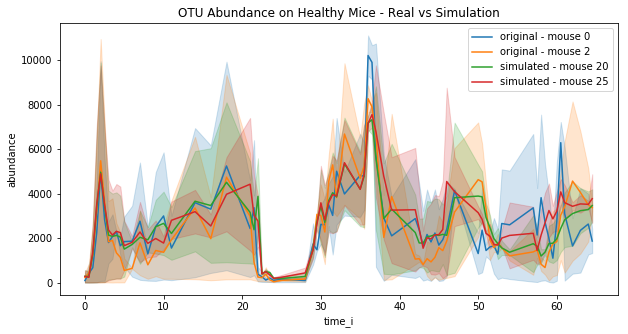

In [15]:
plot_augmented_data(df_all_healthy, 
                    ts_abundance_x_healthy_aug, 
                    {'original':[0,2], 'simulated':[20, 25]}, 
                    title='OTU Abundance on Healthy Mice - Real vs Simulation')

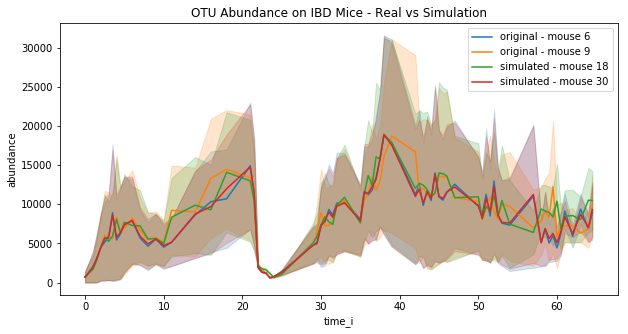

In [74]:
plot_augmented_data(df_all_ibd, 
                    ts_abundance_x_ibd_aug, 
                    {'original':[6,9], 'simulated':[18, 30]}, 
                    title='OTU Abundance on IBD Mice - Real vs Simulation')


**Multidimensional Scaling (MDS)**

In order to have a spacial interpretation of the synthetic data generation, we visualize the result using  manifold learning — a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces [source](https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html). 

Given high-dimensional microbiome time series, MDS seeks a low-dimensional representation of the data that preserves the distance between every pair of points.

In [5]:
def plot_augmented_data_2D(model, X_healthy=ts_abundance_x_healthy_aug, X_ibd=ts_abundance_x_ibd_aug):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    for i in range(X_healthy.shape[0]):
        out = model.fit_transform(X_healthy[i].T)
        if i<4: 
            ax[0].scatter(out[:, 0], out[:, 1], color='blue', label='original - healthy')
        else:
            ax[1].scatter(out[:, 0], out[:, 1], color='green', label='simulated - healthy')
    for i in range(X_ibd.shape[0]):
        out = model.fit_transform(X_ibd[i].T)
        if i<5: 
            ax[0].scatter(out[:, 0], out[:, 1], color='blue', label='original - IBD')
        else:
            ax[1].scatter(out[:, 0], out[:, 1], color='green', label='simulated - IBD')
    ax[0].set_title('MSD - Original Mouse Data \n blue - healthy, black - IBD')
    ax[1].set_title('MSD - Simulated Mouse Data \n blue - healthy, black - IBD')
    plt.axis('equal');

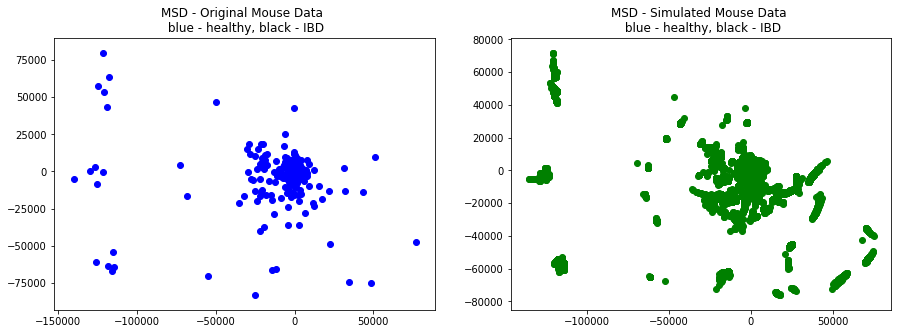

In [6]:
model_mds = MDS(n_components=2, random_state=1)
plot_augmented_data_2D(model_mds)

**Locally linear embedding (LLE)**

Linear embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces, breaks down when the embedding is nonlinear, what is the case for microbiome time series. Instead of preserving the distances between each pair of points, LLE preserves only the distances between neighboring points 

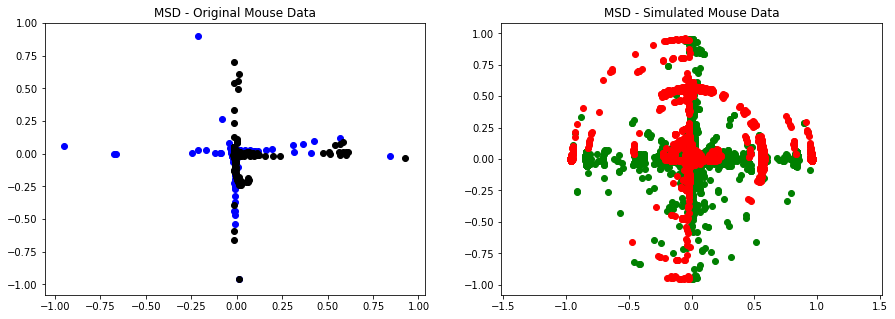

In [29]:
model_lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2, method='modified',
                               eigen_solver='dense')
plot_augmented_data_2D(model_lle)